In [1]:
import os
import nltk
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

In [2]:
path= r'C:\Users\virar\Downloads\archive (3)'
os.chdir(path)

In [3]:
data_df=pd.read_csv('mtsamples.csv')
print(data_df.head(10))
print(data_df.isnull().sum())
data_df.columns

   Unnamed: 0                                        description  \
0           0   A 23-year-old white female presents with comp...   
1           1           Consult for laparoscopic gastric bypass.   
2           2           Consult for laparoscopic gastric bypass.   
3           3                             2-D M-Mode. Doppler.     
4           4                                 2-D Echocardiogram   
5           5   Morbid obesity.  Laparoscopic antecolic anteg...   
6           6   Liposuction of the supraumbilical abdomen, re...   
7           7                                 2-D Echocardiogram   
8           8   Suction-assisted lipectomy - lipodystrophy of...   
9           9                         Echocardiogram and Doppler   

             medical_specialty                                sample_name  \
0         Allergy / Immunology                         Allergic Rhinitis    
1                   Bariatrics   Laparoscopic Gastric Bypass Consult - 2    
2                   

Index(['Unnamed: 0', 'description', 'medical_specialty', 'sample_name',
       'transcription', 'keywords'],
      dtype='object')

<AxesSubplot:>

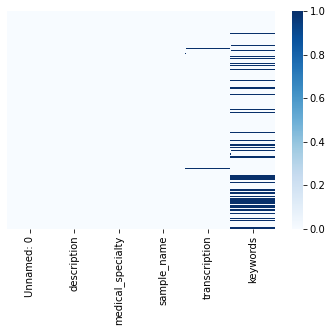

In [4]:
sns.heatmap(data=data_df.isnull(),yticklabels=False,cbar=True,cmap='Blues')

In [5]:
def sent_and_word_count(data):
    w_c=0
    s_c=0
    count={}
    for i in data:
        sentences= sent_tokenize(i)
        s_c=s_c+len(sentences)
        for sent in sentences:
            word_list=word_tokenize(sent)
            for word in word_list:
                if word in count.keys():
                    count[word]+=1
                else:
                    count[word]=1
    w_c=len(count.keys())
    return s_c,w_c
data_df=data_df[data_df['transcription'].notna()]
s_c,w_c=sent_and_word_count(data_df['transcription'].tolist())
print(s_c,w_c)

147007 41910


In [6]:
data_df['medical_specialty'].unique()

array([' Allergy / Immunology', ' Bariatrics',
       ' Cardiovascular / Pulmonary', ' Neurology', ' Dentistry',
       ' Urology', ' General Medicine', ' Surgery', ' Speech - Language',
       ' SOAP / Chart / Progress Notes', ' Sleep Medicine',
       ' Rheumatology', ' Radiology', ' Psychiatry / Psychology',
       ' Podiatry', ' Physical Medicine - Rehab',
       ' Pediatrics - Neonatal', ' Pain Management', ' Orthopedic',
       ' Ophthalmology', ' Office Notes', ' Obstetrics / Gynecology',
       ' Neurosurgery', ' Nephrology', ' Letters',
       ' Lab Medicine - Pathology', ' IME-QME-Work Comp etc.',
       ' Hospice - Palliative Care', ' Hematology - Oncology',
       ' Gastroenterology', ' ENT - Otolaryngology', ' Endocrinology',
       ' Emergency Room Reports', ' Discharge Summary',
       ' Diets and Nutritions', ' Dermatology',
       ' Cosmetic / Plastic Surgery', ' Consult - History and Phy.',
       ' Chiropractic', ' Autopsy'], dtype=object)

In [7]:
#filtering the data that has more than 50 values
data_df=data_df.groupby(data_df['medical_specialty']).filter(lambda x:x.shape[0]>=50) 
for name,value in data_df.groupby(data_df['medical_specialty']):
    print(name+': '+str(len(value)))
    print(value['transcription'].head(1))

 Cardiovascular / Pulmonary: 371
3    2-D M-MODE: , ,1.  Left atrial enlargement wit...
Name: transcription, dtype: object
 Consult - History and Phy.: 516
4081    SUBJECTIVE:,  The patient presents with Mom fo...
Name: transcription, dtype: object
 Discharge Summary: 108
3877    The patient made some progress during therapy....
Name: transcription, dtype: object
 ENT - Otolaryngology: 96
3687    Patient had a normal MRI and normal neurologic...
Name: transcription, dtype: object
 Emergency Room Reports: 75
3802    PROCEDURE: , Urgent cardiac catheterization wi...
Name: transcription, dtype: object
 Gastroenterology: 224
3455    HISTORY OF PRESENT ILLNESS:,  Ms. Connor is a ...
Name: transcription, dtype: object
 General Medicine: 259
19    HISTORY OF PRESENT ILLNESS:,  The patient is a...
Name: transcription, dtype: object
 Hematology - Oncology: 90
3110    REASON FOR CONSULTATION: , Thyroid mass diagno...
Name: transcription, dtype: object
 Nephrology: 81
2974    EXAM: , Bilateral re

Unnamed: 0           4647
description          2304
medical_specialty      22
sample_name          2328
transcription        2325
keywords             3570
dtype: int64


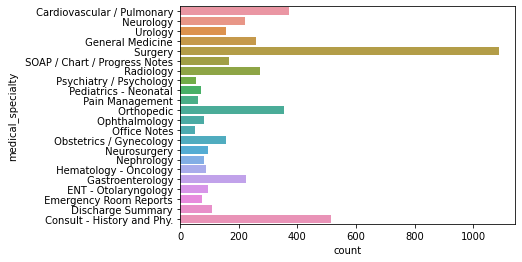

In [8]:
print(data_df.nunique())
sns.countplot(y='medical_specialty',data=data_df)
plt.show()

In [9]:
data=data_df[['transcription', 'medical_specialty']]
data=data[data['transcription'].notnull()]
data['transcription'].tolist()[1]

'1.  The left ventricular cavity size and wall thickness appear normal.  The wall motion and left ventricular systolic function appears hyperdynamic with estimated ejection fraction of 70% to 75%.  There is near-cavity obliteration seen.  There also appears to be increased left ventricular outflow tract gradient at the mid cavity level consistent with hyperdynamic left ventricular systolic function.  There is abnormal left ventricular relaxation pattern seen as well as elevated left atrial pressures seen by Doppler examination.,2.  The left atrium appears mildly dilated.,3.  The right atrium and right ventricle appear normal.,4.  The aortic root appears normal.,5.  The aortic valve appears calcified with mild aortic valve stenosis, calculated aortic valve area is 1.3 cm square with a maximum instantaneous gradient of 34 and a mean gradient of 19 mm.,6.  There is mitral annular calcification extending to leaflets and supportive structures with thickening of mitral valve leaflets with mi

In [10]:
import string
import regex as re
from nltk.stem import WordNetLemmatizer
def text_clean(text):
    text=text.translate(str.maketrans('','',string.punctuation)) #removing punctuation
    text=''.join([i for i in text if not i.isdigit()]) #removing digits
    a=re.compile('[/(){}\[\]\|@,;]')
    final_text=text.lower()
    final_text=a.sub('',final_text)   #removing every special characters
    return final_text
def lemmatize(text):
    list_words=[]    #lemmatizing every sentence in the text
    lemmatizer = WordNetLemmatizer() 
    sentences=sent_tokenize(text)
    for i in range(len(sentences)):
        words=word_tokenize(sentences[i])
        for word in words:
            list_words.append(lemmatizer.lemmatize(word))
    return ' '.join(list_words)
data['transcription']=data['transcription'].apply(lemmatize)
data['transcription']=data['transcription'].apply(text_clean)


In [18]:
data2=data.loc[1:2000,['transcription','medical_specialty']]
data.shape

(4647, 2)

In [12]:
vectorizer= TfidfVectorizer(stop_words='english',ngram_range=(1,3),max_df=0.85,analyzer='word')
id_matrix=vectorizer.fit_transform(data2['transcription'].tolist())
len(vectorizer.get_feature_names())

539024

In [20]:
vectorizer.get_feature_names()[10:13]

['aa periodic moment', 'aa present', 'aa present going']

In [14]:
#pd.DataFrame(id_matrix.toarray()).astype('float16').info(memory_usage='deep')

In [15]:
import gc
gc.collect()
a=id_matrix[0]
a=pd.DataFrame(a.T.todense(),index=vectorizer.get_feature_names(),columns=['value'])
a.shape

(539024, 1)

In [22]:
id_matrix.astype('float16')

<1865x539024 sparse matrix of type '<class 'numpy.float16'>'
	with 1142429 stored elements in Compressed Sparse Row format>

In [24]:
new_id_matrix=pd.DataFrame(id_matrix.toarray())

In [ ]:
new_id_matrix=new_id_matrix.astype('float16')